In [108]:
import pandas as pd
import numpy as np
import os

os.chdir('C:/Users/Venia/Desktop/political-manifestos')
text=pd.read_csv("data/english_text.csv")
core = pd.read_csv("data/english_core.csv")

In [109]:
words_to_remove = ['canada','canadians','america','americans','britain']
country_list = ['Canada','United Kingdom','United States']

In [110]:
df = pd.merge(text,core, on = 'key')

In [111]:
from string import punctuation, digits
import re

def clean_text(x):
    x = x.lower()
    x = x.replace("\n", " ")
    x = x.replace('\t', ' ')
    x = x.replace("\'", '')
    x=x.strip()
    remove_digits = str.maketrans('', '', digits)
    regex = re.compile('[%s]' % re.escape(punctuation))
    x = regex.sub('', x)
    x = x.translate(remove_digits)
    return x 
    

In [112]:
df['text_clean'] = df['text'].apply(lambda x: clean_text(x))

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [114]:
tfidf = TfidfVectorizer(stop_words = 'english', max_features = 10000)
tfidf_mat = tfidf.fit_transform(df['text_clean'])

In [115]:
tfidf_mat = tfidf_mat.toarray()

In [116]:
tfidf_df = pd.DataFrame(tfidf_mat, columns = tfidf.get_feature_names())

In [117]:
tfidf_df = pd.merge(df[['countryname']], tfidf_df, left_index=True,right_index=True)

In [118]:
tfidf_scores = tfidf_df.groupby('countryname')[tfidf.get_feature_names()].mean().T

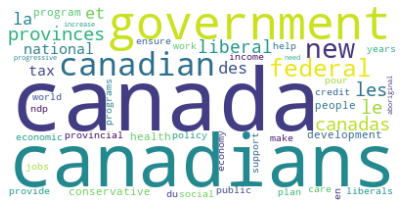

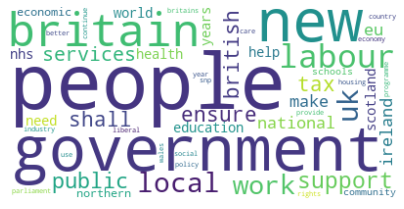

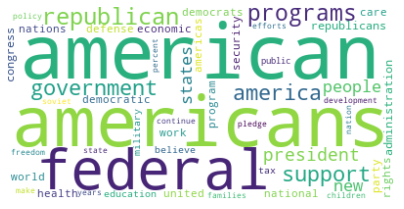

In [119]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for country in country_list:
    wordcloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(tfidf_scores[country])
    plt.figure( figsize=(7,5) )
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("visuals/word_clouds/{}".format(country))

In [172]:
from collections import defaultdict
from gensim import corpora
stoplist = set('for a of the and to in me myself i'.split())

texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in df['text_clean']
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [126]:
from gensim import models
import gensim

In [138]:
lis = []
for i, k in df.iterrows():
    country = k['countryname']
    text = k['text_clean']
    tokens = gensim.utils.simple_preprocess(text)
    lis.append(gensim.models.doc2vec.TaggedDocument(tokens, [i]))

In [150]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=200, min_count=2, epochs=40)
model.build_vocab(lis)


In [151]:
ranks = []
second_ranks = []
for doc_id in range(len(lis)):
    inferred_vector = model.infer_vector(lis[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [159]:
model.wv.most_similar("united", topn=10)

[('rating', 0.2933396100997925),
 ('abu', 0.2762450575828552),
 ('ratifying', 0.27262750267982483),
 ('certify', 0.26436835527420044),
 ('debtors', 0.26064109802246094),
 ('apparatus', 0.25093868374824524),
 ('uniformly', 0.24764204025268555),
 ('emancipation', 0.24578163027763367),
 ('leakage', 0.24253223836421967),
 ('inhérent', 0.24242003262043)]

In [160]:
lis = []
for i, line in enumerate(df['text_clean'].values):
    lis.append(gensim.utils.simple_preprocess(line))
    

In [174]:
w2v = gensim.models.Word2Vec(sentences=texts)


In [179]:
vectors = w2v.wv.vectors
labels = w2v.wv.index_to_key

In [190]:
w2v.wv.most_similar("globalization", topn=10)

[('instability', 0.8916173577308655),
 ('pandemic', 0.8574934005737305),
 ('sticking', 0.8560877442359924),
 ('optimistic', 0.8534607887268066),
 ('signs', 0.8517345786094666),
 ('europes', 0.8515222668647766),
 ('withstand', 0.8499816656112671),
 ('necessity', 0.8495199084281921),
 ('indispensable', 0.8492788076400757),
 ('l’effort', 0.8476989269256592)]